In [324]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [325]:
!kaggle datasets download -d avikasliwal/used-cars-price-prediction

used-cars-price-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [326]:
import zipfile
zip_ref = zipfile.ZipFile('/content/used-cars-price-prediction.zip')
zip_ref.extractall('/content')
zip_ref.close()

### **Importing Libraries**

In [328]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense , BatchNormalization , Dropout
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns

## **Loading Data**

In [329]:
df = pd.read_csv('/content/train-data.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


## **Data Analysis**

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [331]:
df.describe()

,Unnamed: 0,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,3009.000000,2013.358199,5.873838e+04,5.278735,9.479468
std,1737.679967,3.269742,9.126884e+04,0.808840,11.187917
min,0.000000,1998.000000,1.710000e+02,0.000000,0.440000
25%,1504.500000,2011.000000,3.400000e+04,5.000000,3.500000
50%,3009.000000,2014.000000,5.300000e+04,5.000000,5.640000
75%,4513.500000,2016.000000,7.300000e+04,5.000000,9.950000
max,6018.000000,2019.000000,6.500000e+06,10.000000,160.000000


In [245]:
df.isna().sum()

Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

## **EDA**

<Axes: xlabel='Price', ylabel='Count'>

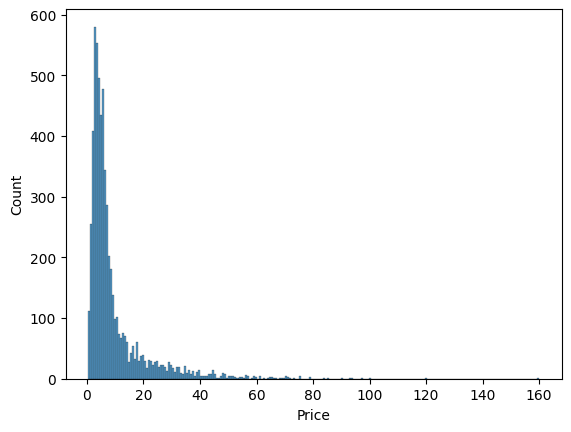

In [332]:
sns.histplot(df['Price'])

<Axes: xlabel='Year', ylabel='Price'>

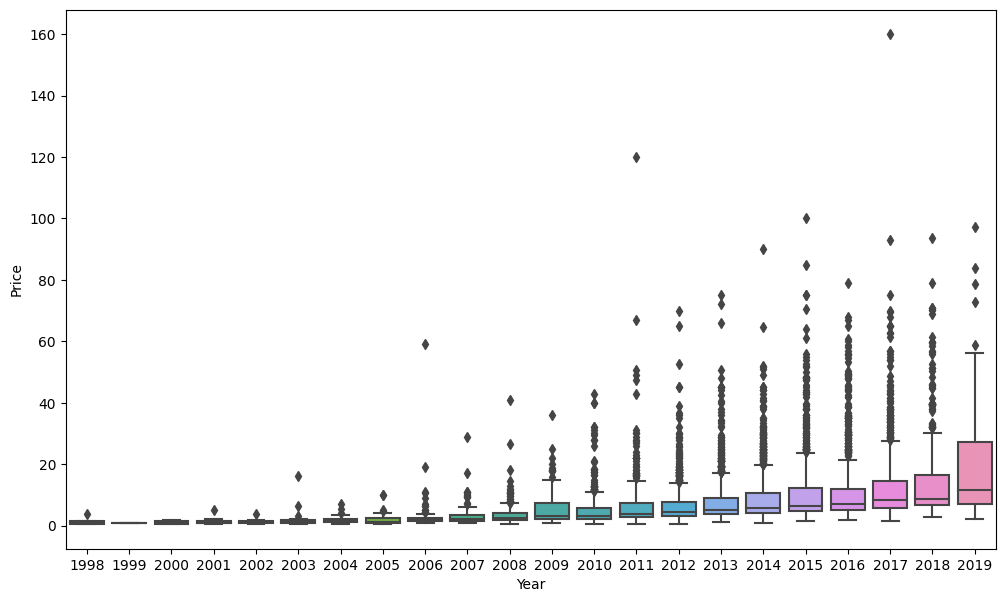

In [335]:
plt.figure(figsize = (12,7))
sns.boxplot(x = 'Year' , y= 'Price', data=df)

<Axes: xlabel='Fuel_Type', ylabel='Price'>

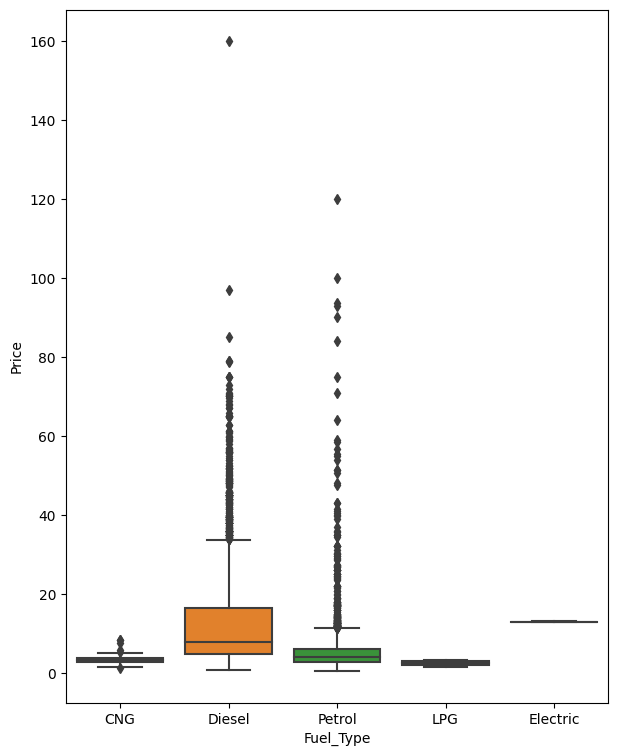

In [339]:
plt.figure(figsize = (7,9))
sns.boxplot(x = 'Fuel_Type' , y= 'Price', data=df)

<Axes: xlabel='Transmission', ylabel='Price'>

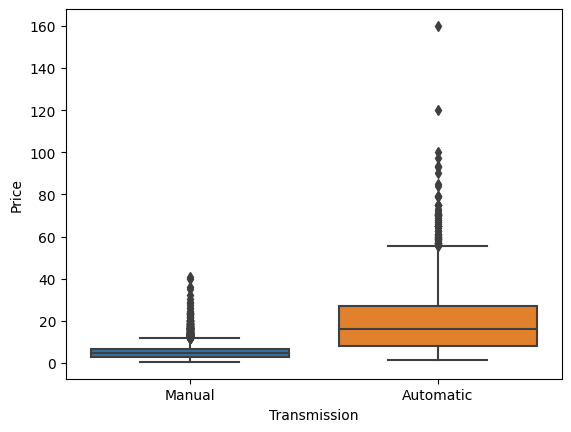

In [340]:
sns.boxplot(x = 'Transmission' , y= 'Price', data=df)

<Axes: xlabel='Owner_Type', ylabel='Price'>

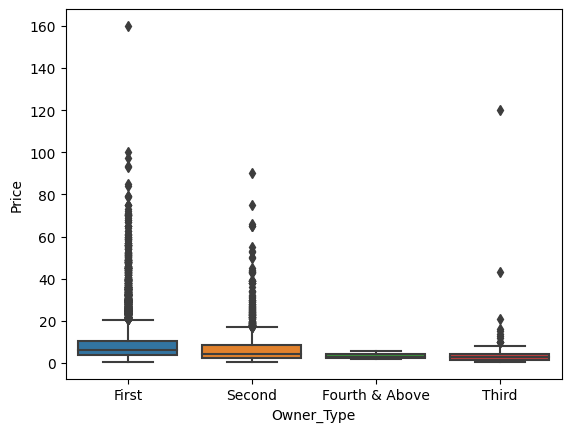

In [341]:
sns.boxplot(x = 'Owner_Type' , y= 'Price', data=df)

<Axes: xlabel='Seats', ylabel='Price'>

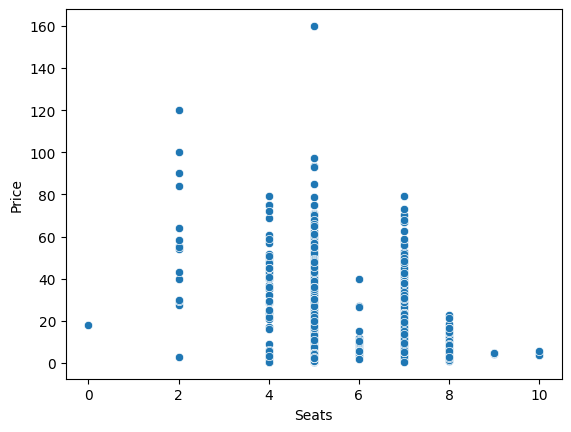

In [343]:
sns.scatterplot(data=df , x = 'Seats', y ='Price')

<Axes: xlabel='Location', ylabel='Price'>

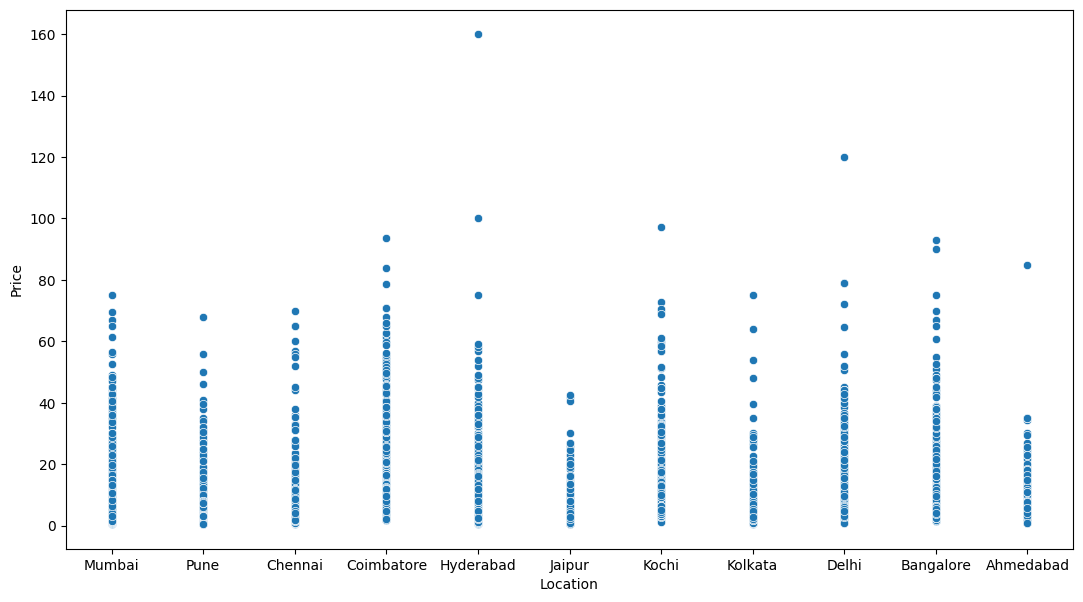

In [345]:
plt.figure(figsize = (13,7))
sns.scatterplot(data=df , x = 'Location', y ='Price')

## **Pre-Processing**

In [346]:
df.drop(['Unnamed: 0','Name','New_Price'],axis=1,inplace=True)
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [347]:
df.dropna(axis=0,inplace=True)
df.isna().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

In [348]:
df['Mileage'] = df['Mileage'].str.replace(' km/kg','')
df['Mileage'] = df['Mileage'].str.replace(' kmpl','')
df['Engine'] = df['Engine'].str.replace(' CC','')
df['Power'] = df['Power'].str.replace(' bhp','')

df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,26.6,998,58.16,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.2,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.2,1199,88.7,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968,140.8,5.0,17.74


In [349]:
df.shape

(5975, 11)

In [350]:
np.unique(df['Power'])

array(['100', '100.6', '101', '102', '102.5', '102.53', '102.57', '103',
       '103.2', '103.25', '103.3', '103.5', '103.52', '103.6', '104',
       '104.68', '105', '105.5', '106', '107.2', '107.3', '108.4',
       '108.45', '108.49', '108.495', '108.5', '108.62', '110', '110.4',
       '110.5', '112', '112.2', '112.4', '113.98', '114', '114.4', '115',
       '116.3', '116.4', '116.6', '116.9', '117.3', '118', '118.3',
       '118.6', '120', '120.33', '120.7', '121.3', '121.36', '121.4',
       '122', '123.24', '123.37', '123.7', '125', '126.2', '126.24',
       '126.3', '126.32', '127', '130', '130.2', '130.3', '132', '134',
       '135.1', '136', '138', '138.02', '138.03', '138.08', '138.1',
       '139.01', '139.07', '140', '140.8', '141', '141.1', '142', '143',
       '144', '147.5', '147.51', '147.6', '147.8', '147.9', '148',
       '148.31', '149.92', '150', '152', '152.88', '153.86', '154', '155',
       '156', '157.7', '157.75', '157.8', '158', '158.2', '158.8', '160',
      

In [351]:
df[df['Power']=='null']['Power'].value_counts()

null    103
Name: Power, dtype: int64

In [352]:
df= df[df['Power'].str.contains('null')==False]

In [353]:
df['Mileage'] = df['Mileage'].astype(float)
df['Engine'] = df['Engine'].astype(float)
df['Power'] = df['Power'].astype(float)

<ipython-input-353-fd324f879156>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mileage'] = df['Mileage'].astype(float)
<ipython-input-353-fd324f879156>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Engine'] = df['Engine'].astype(float)
<ipython-input-353-fd324f879156>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5872 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           5872 non-null   object 
 1   Year               5872 non-null   int64  
 2   Kilometers_Driven  5872 non-null   int64  
 3   Fuel_Type          5872 non-null   object 
 4   Transmission       5872 non-null   object 
 5   Owner_Type         5872 non-null   object 
 6   Mileage            5872 non-null   float64
 7   Engine             5872 non-null   float64
 8   Power              5872 non-null   float64
 9   Seats              5872 non-null   float64
 10  Price              5872 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 550.5+ KB


**Splitting the categorical and numerical features**

In [356]:
df_categories = df.select_dtypes(include = 'object').columns
df_numerical = df.select_dtypes(include = 'number').columns
print('Categorical columns are : ',df_categories)
print('\n')
print('Numerical columns are : ',df_numerical)

Categorical columns are :  Index(['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'], dtype='object')


Numerical columns are :  Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price'],
      dtype='object')


In [357]:
print('Categories in Location :',np.unique(df[df_categories[0]]))
print('\n')
print('Categories in Fuel Type :',np.unique(df[df_categories[1]]))
print('\n')
print('Categories in Transmission :',np.unique(df[df_categories[2]]))
print('\n')
print('Categories in Owner Type :',np.unique(df[df_categories[3]]))

Categories in Location : ['Ahmedabad' 'Bangalore' 'Chennai' 'Coimbatore' 'Delhi' 'Hyderabad'
 'Jaipur' 'Kochi' 'Kolkata' 'Mumbai' 'Pune']


Categories in Fuel Type : ['CNG' 'Diesel' 'LPG' 'Petrol']


Categories in Transmission : ['Automatic' 'Manual']


Categories in Owner Type : ['First' 'Fourth & Above' 'Second' 'Third']


## **Encoding the categorical variables**

In [358]:
from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder

ohe = OneHotEncoder()
categories_for_ohe = ['Location','Fuel_Type','Transmission']

In [359]:
for i in range (len(categories_for_ohe)):
  categories_for_ohe[i] = ohe.fit_transform(np.array(df[categories_for_ohe[i]]).reshape(-1,1)).toarray()
  labels = ohe.categories_
  categories_for_ohe[i] = pd.DataFrame(categories_for_ohe[i] , columns=labels)

In [360]:
categories_for_ohe[0].head()

,Ahmedabad,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,Mumbai,Pune
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [361]:
categories_for_ohe[0].columns

MultiIndex([( 'Ahmedabad',),
            ( 'Bangalore',),
            (   'Chennai',),
            ('Coimbatore',),
            (     'Delhi',),
            ( 'Hyderabad',),
            (    'Jaipur',),
            (     'Kochi',),
            (   'Kolkata',),
            (    'Mumbai',),
            (      'Pune',)],
           )

In [362]:
categories_for_ohe[0].columns = ['Ahmedabad','Bangalore','Chennai','Coimbatore'	,'Delhi'	,'Hyderabad'	,'Jaipur',	'Kochi',	'Kolkata'	,'Mumbai'	,'Pune']

In [363]:
categories_for_ohe[0].columns

Index(['Ahmedabad', 'Bangalore', 'Chennai', 'Coimbatore', 'Delhi', 'Hyderabad',
       'Jaipur', 'Kochi', 'Kolkata', 'Mumbai', 'Pune'],
      dtype='object')

In [364]:
categories_for_ohe[1].columns = ['CNG',	'Diesel'	,'LPG'	,'Petrol']
categories_for_ohe[1].head()

,CNG,Diesel,LPG,Petrol
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [365]:
categories_for_ohe[2].columns = [	'Automatic',	'Manual']
categories_for_ohe[2].head()

,Automatic,Manual
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [366]:
owner_type = df[df_categories[3]]
owner_type = owner_type.replace({"First":1,"Second":2,"Third": 3,"Fourth & Above":4})
owner_type = pd.DataFrame(owner_type )
owner_type.head()

,Owner_Type
0,1
1,1
2,1
3,1
4,2


In [367]:
categories_for_ohe[0].shape

(5872, 11)

In [368]:
categories_for_ohe[1].shape

(5872, 4)

In [369]:
categories_for_ohe[2].shape

(5872, 2)

In [370]:
owner_type.shape

(5872, 1)

In [371]:
df.shape

(5872, 11)

In [372]:
categories_df_1 = pd.concat([categories_for_ohe[0],categories_for_ohe[1],categories_for_ohe[2]],axis=1)
categories_df_1.head()

,Ahmedabad,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,Mumbai,Pune,CNG,Diesel,LPG,Petrol,Automatic,Manual
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [373]:
categories_df_1.shape

(5872, 17)

In [374]:
owner_type.reset_index(drop = True,inplace = True)
categories_df_1.reset_index(drop = True,inplace = True)

categories_df_2 = pd.concat([owner_type,categories_df_1],axis=1)

categories_df_2.reset_index(drop = True,inplace = True)

In [375]:
categories_df_2.shape

(5872, 18)

In [376]:
categories_df_2.head()

,Owner_Type,Ahmedabad,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,Mumbai,Pune,CNG,Diesel,LPG,Petrol,Automatic,Manual
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# **Scaling the numerical features**

In [377]:
from sklearn.preprocessing import MinMaxScaler
df_numerical = df_numerical[:len(df_numerical)-1]
df_numerical

Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats'], dtype='object')

In [378]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[df_numerical])
scaled_df = pd.DataFrame(scaled_df,columns  =df_numerical )
scaled_df.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
0,0.571429,0.011051,0.793083,0.069594,0.045569,0.375
1,0.809524,0.006282,0.586464,0.178266,0.174971,0.375
2,0.619048,0.007051,0.542636,0.106997,0.103652,0.375
3,0.666667,0.013359,0.619261,0.116115,0.103766,0.625
4,0.714286,0.006231,0.453190,0.250093,0.202739,0.375


In [379]:
scaled_df.shape

(5872, 6)

# **Combining the Preprocessed data**

In [380]:
final_df = pd.concat([categories_df_2,scaled_df ],axis=1)
final_df.shape

(5872, 24)

In [381]:
final_df.head()

,Owner_Type,Ahmedabad,Bangalore,Chennai,Coimbatore,Delhi,Hyderabad,Jaipur,Kochi,Kolkata,...,LPG,Petrol,Automatic,Manual,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.571429,0.011051,0.793083,0.069594,0.045569,0.375
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.809524,0.006282,0.586464,0.178266,0.174971,0.375
2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.619048,0.007051,0.542636,0.106997,0.103652,0.375
3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.666667,0.013359,0.619261,0.116115,0.103766,0.625
4,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.714286,0.006231,0.453190,0.250093,0.202739,0.375


# **Spliting the data into train and test set**

In [281]:
X_train,X_test,y_train,y_test = train_test_split(final_df,df['Price'],
                                                 test_size=0.25,
                                                 shuffle = True)

print("shape of X_train : ",X_train.shape)
print("shape of y_train : ",y_train.shape)
print("shape of X_test : ",X_test.shape)
print("shape of y_test : ",y_test.shape)

shape of X_train :  (4404, 24)
shape of y_train :  (4404,)
shape of X_test :  (1468, 24)
shape of y_test :  (1468,)


## **Model Building**

In [303]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.1 MB/s eta 0:00:00


In [305]:
def build_model(hp):

  model = Sequential()

  counter = 0
  for i in range( hp.Int('num_layers',min_value=1 , max_value=5)):
    if counter == 0:
      model.add(Dense(hp.Int('nodes' + str(i),min_value=32,max_value=64,step = 8), activation = 'relu', input_dim =24 ))
    else :
       model.add(Dense(hp.Int('nodes' + str(i),min_value=32,max_value=64,step = 8), activation = 'relu'))

    counter = counter+ 1


  model.add(Dense(1,activation = hp.Choice('activations' ,['relu','linear'])))

  model.compile(optimizer='adam' , loss = 'mean_squared_error', metrics=['accuracy'])

  return model


In [309]:
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy',
                        max_trials = 6,
                        directory='test',
                        project_name='car_price')

In [310]:
tuner.search(X_train, y_train, epochs=30,validation_data = (X_test,y_test) )

Trial 6 Complete [00h 00m 22s]
val_accuracy: 0.00136239780113101

Best val_accuracy So Far: 0.00136239780113101
Total elapsed time: 00h 01m 55s


In [311]:
tuner.results_summary()

Results summary
Results in test/car_price
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
num_layers: 1
nodes0: 56
activations: relu
nodes1: 32
nodes2: 32
nodes3: 48
nodes4: 40
Score: 0.00136239780113101

Trial 2 summary
Hyperparameters:
num_layers: 5
nodes0: 64
activations: relu
nodes1: 32
nodes2: 48
nodes3: 56
nodes4: 56
Score: 0.00136239780113101

Trial 3 summary
Hyperparameters:
num_layers: 2
nodes0: 56
activations: linear
nodes1: 40
nodes2: 40
nodes3: 40
nodes4: 40
Score: 0.00136239780113101

Trial 4 summary
Hyperparameters:
num_layers: 1
nodes0: 56
activations: linear
nodes1: 32
nodes2: 48
nodes3: 56
nodes4: 56
Score: 0.00136239780113101

Trial 5 summary
Hyperparameters:
num_layers: 4
nodes0: 56
activations: relu
nodes1: 56
nodes2: 48
nodes3: 40
nodes4: 40
Score: 0.00136239780113101

Trial 0 summary
Hyperparameters:
num_layers: 5
nodes0: 32
activations: relu
nodes1: 32
nodes2: 32
nodes3: 32
nodes4: 32
Score: 0.0


In [312]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 1,
 'nodes0': 56,
 'activations': 'relu',
 'nodes1': 32,
 'nodes2': 32,
 'nodes3': 48,
 'nodes4': 40}

In [318]:
model = tuner.get_best_models()[0]

In [319]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                1400      
                                                                 
 dense_1 (Dense)             (None, 1)                 57        
                                                                 
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


In [320]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping("val_accuracy",min_delta = 0.01,patience=3 ,verbose=1,mode = 'auto')

In [321]:
model.fit(X_train,y_train,epochs=100,callbacks = callback , validation_data = (X_test,y_test),initial_epoch=30)

Epoch 31/100
138/138 [==============================] - 1s 4ms/step - loss: 101.1356 - accuracy: 0.0030 - val_loss: 88.9610 - val_accuracy: 0.0014
Epoch 32/100
138/138 [==============================] - 0s 2ms/step - loss: 70.9906 - accuracy: 0.0030 - val_loss: 70.4481 - val_accuracy: 0.0014
Epoch 33/100
138/138 [==============================] - 0s 2ms/step - loss: 61.3900 - accuracy: 0.0020 - val_loss: 64.9759 - val_accuracy: 0.0014
Epoch 34/100
138/138 [==============================] - 0s 2ms/step - loss: 57.4091 - accuracy: 0.0011 - val_loss: 61.4163 - val_accuracy: 6.8120e-04
Epoch 34: early stopping


## **Model evaluation**

In [322]:
from sklearn.metrics import r2_score

In [323]:
r2_score(y_test , model.predict(X_test))

46/46 [==============================] - 0s 1ms/step


0.5308093918618246